In [4]:
from xopt import Xopt
from xopt.utils import read_xopt_csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from pmd_beamphysics import ParticleGroup, particle_paths, single_particle
from pmd_beamphysics.plot import density_plot
from distgen import Generator
import yaml
import pandas as pd
from glob import glob

In [66]:
# find all popolation files and sort by generation
pop_files = sorted(glob("temp/cnsga_population*"))
len(pop_files)

21

In [67]:
# Read all population files and combine into one dataframe
all_populations = []
for i, file in enumerate(pop_files):
    df = read_xopt_csv(file)
    df['generation'] = i
    all_populations.append(df)

# Combine all generations
pop_df = pd.concat(all_populations, ignore_index=True)
print(f"Total evaluations: {len(pop_df)}")
print(f"Number of generations: {pop_df['generation'].nunique()}")
pop_df.head()

Total evaluations: 672
Number of generations: 21


,phase,phase3,voltage,voltage3,gamma_error,energy_spread,sigma_energy,mean_gamma,n_alive,ID,xopt_runtime,xopt_error,generation
0,-0.080268,0.482154,1.407876e+07,1.206942,0.001346,0.038359,479606.983567,24.468201,10000,d07d0d9f770c7b7158c8982be82ffcc1,2395.688321,False,0
1,-0.046099,0.492040,1.402097e+07,1.396069,0.001851,0.019822,268347.749210,26.492882,10000,1f1d2801aeed2f6a001cf3b7d2376898,2530.569644,False,0
2,-0.039202,0.467679,1.166894e+07,1.168918,0.012717,0.009537,109830.519260,22.535647,10000,808fe4ebcc54ed663971540c50b4c220,2587.502971,False,0
3,0.039433,0.514804,1.355746e+07,0.898923,0.000104,0.056582,741888.410917,25.658933,10000,3d8893505c33729a1a1a6efa76da22de,2665.193947,False,0
4,-0.016694,0.438187,1.449096e+07,1.171891,0.017514,0.008852,130092.382466,28.761410,10000,6dd1644629c764759edca6582f28016b,2785.652988,False,0


In [68]:
# Define variables and objectives
variables = ['phase', 'phase3', 'voltage', 'voltage3']
objectives = ['gamma_error', 'energy_spread']

print("Variables:", variables)
print("Objectives:", objectives)
print("\nData ranges:")
for var in variables:
    print(f"{var}: [{pop_df[var].min():.6f}, {pop_df[var].max():.6f}]")
for obj in objectives:
    print(f"{obj}: [{pop_df[obj].min():.2e}, {pop_df[obj].max():.2e}]")

Variables: ['phase', 'phase3', 'voltage', 'voltage3']
Objectives: ['gamma_error', 'energy_spread']

Data ranges:
phase: [-0.094314, 0.097523]
phase3: [0.400426, 0.593264]
voltage: [10074463.157772, 14978124.550914]
voltage3: [0.809488, 1.478916]
gamma_error: [2.25e-09, 1.38e-01]
energy_spread: [2.94e-03, 1.91e-01]


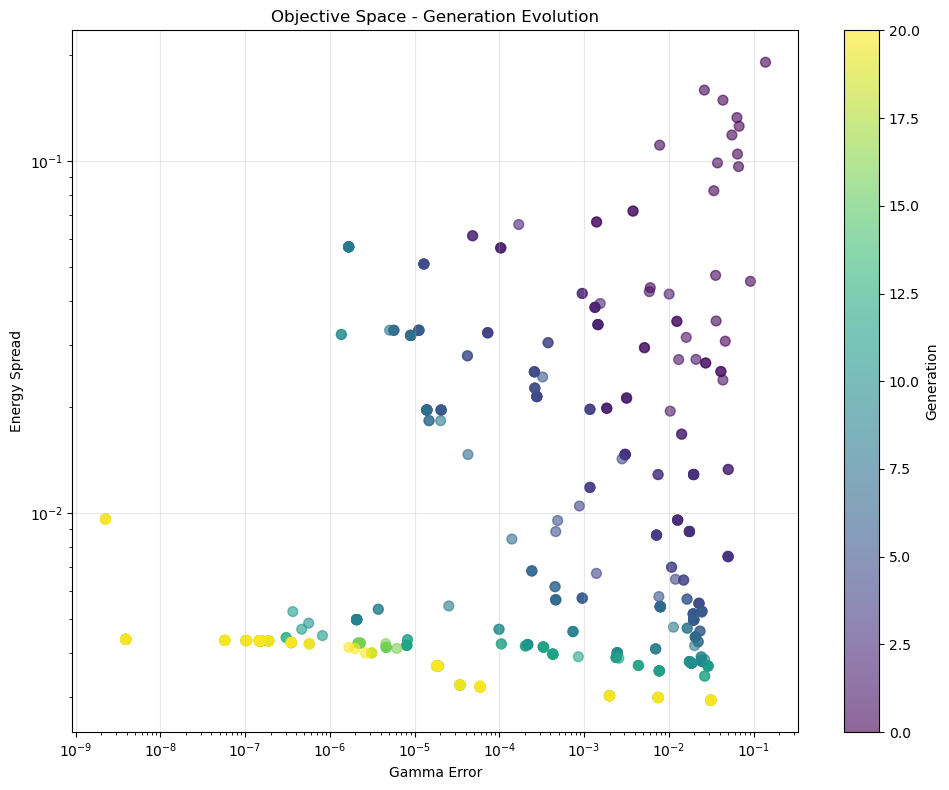

In [69]:
# 2. Objective space plot (Pareto front)
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with color based on generation
scatter = ax.scatter(pop_df['gamma_error'], pop_df['energy_spread'], 
                    c=pop_df['generation'], cmap='viridis', alpha=0.6, s=50)

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Objective Space - Generation Evolution')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Generation')

plt.tight_layout()
plt.show()

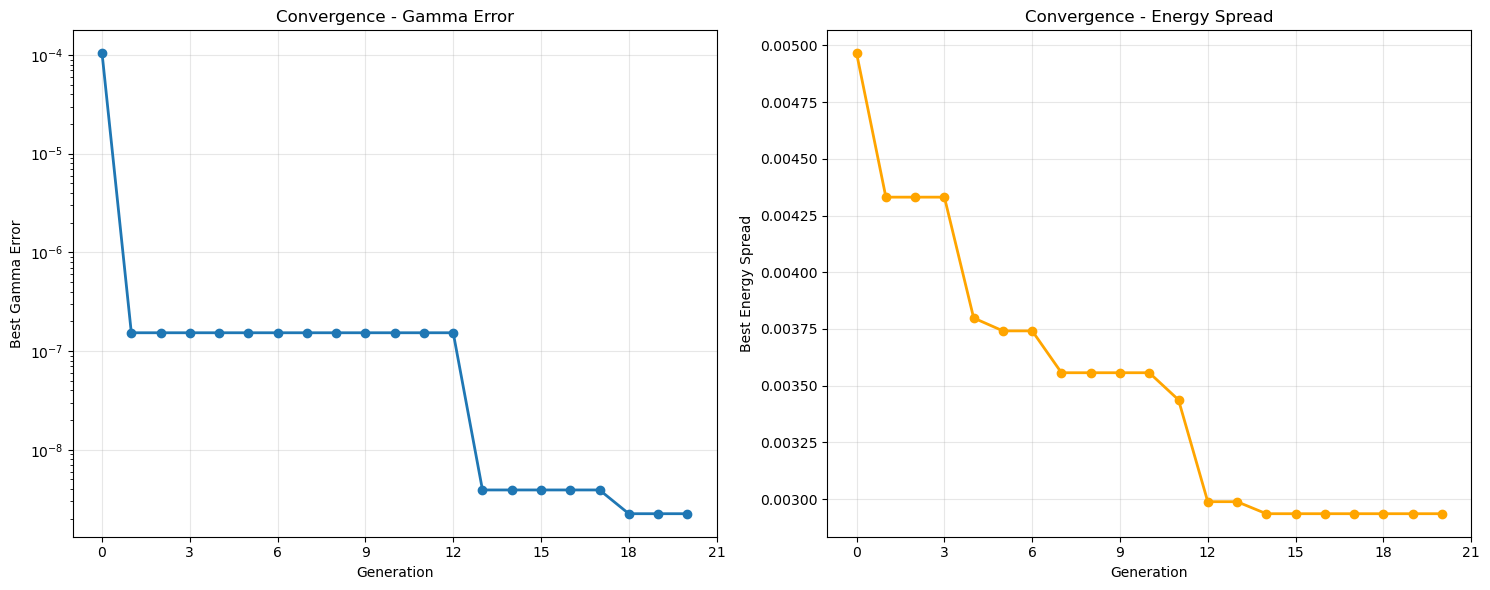

In [70]:
# 3. Convergence analysis - Best objectives over generations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate best values per generation
best_per_gen = pop_df.groupby('generation').agg({
    'gamma_error': 'min',
    'energy_spread': 'min'
}).reset_index()

# Plot convergence
axes[0].plot(best_per_gen['generation'], best_per_gen['gamma_error'], 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Best Gamma Error')
axes[0].set_title('Convergence - Gamma Error')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
# Force integer x-ticks
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axes[1].plot(best_per_gen['generation'], best_per_gen['energy_spread'], 'o-', linewidth=2, markersize=6, color='orange')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Best Energy Spread')
axes[1].set_title('Convergence - Energy Spread')
axes[1].grid(True, alpha=0.3)
# Force integer x-ticks
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

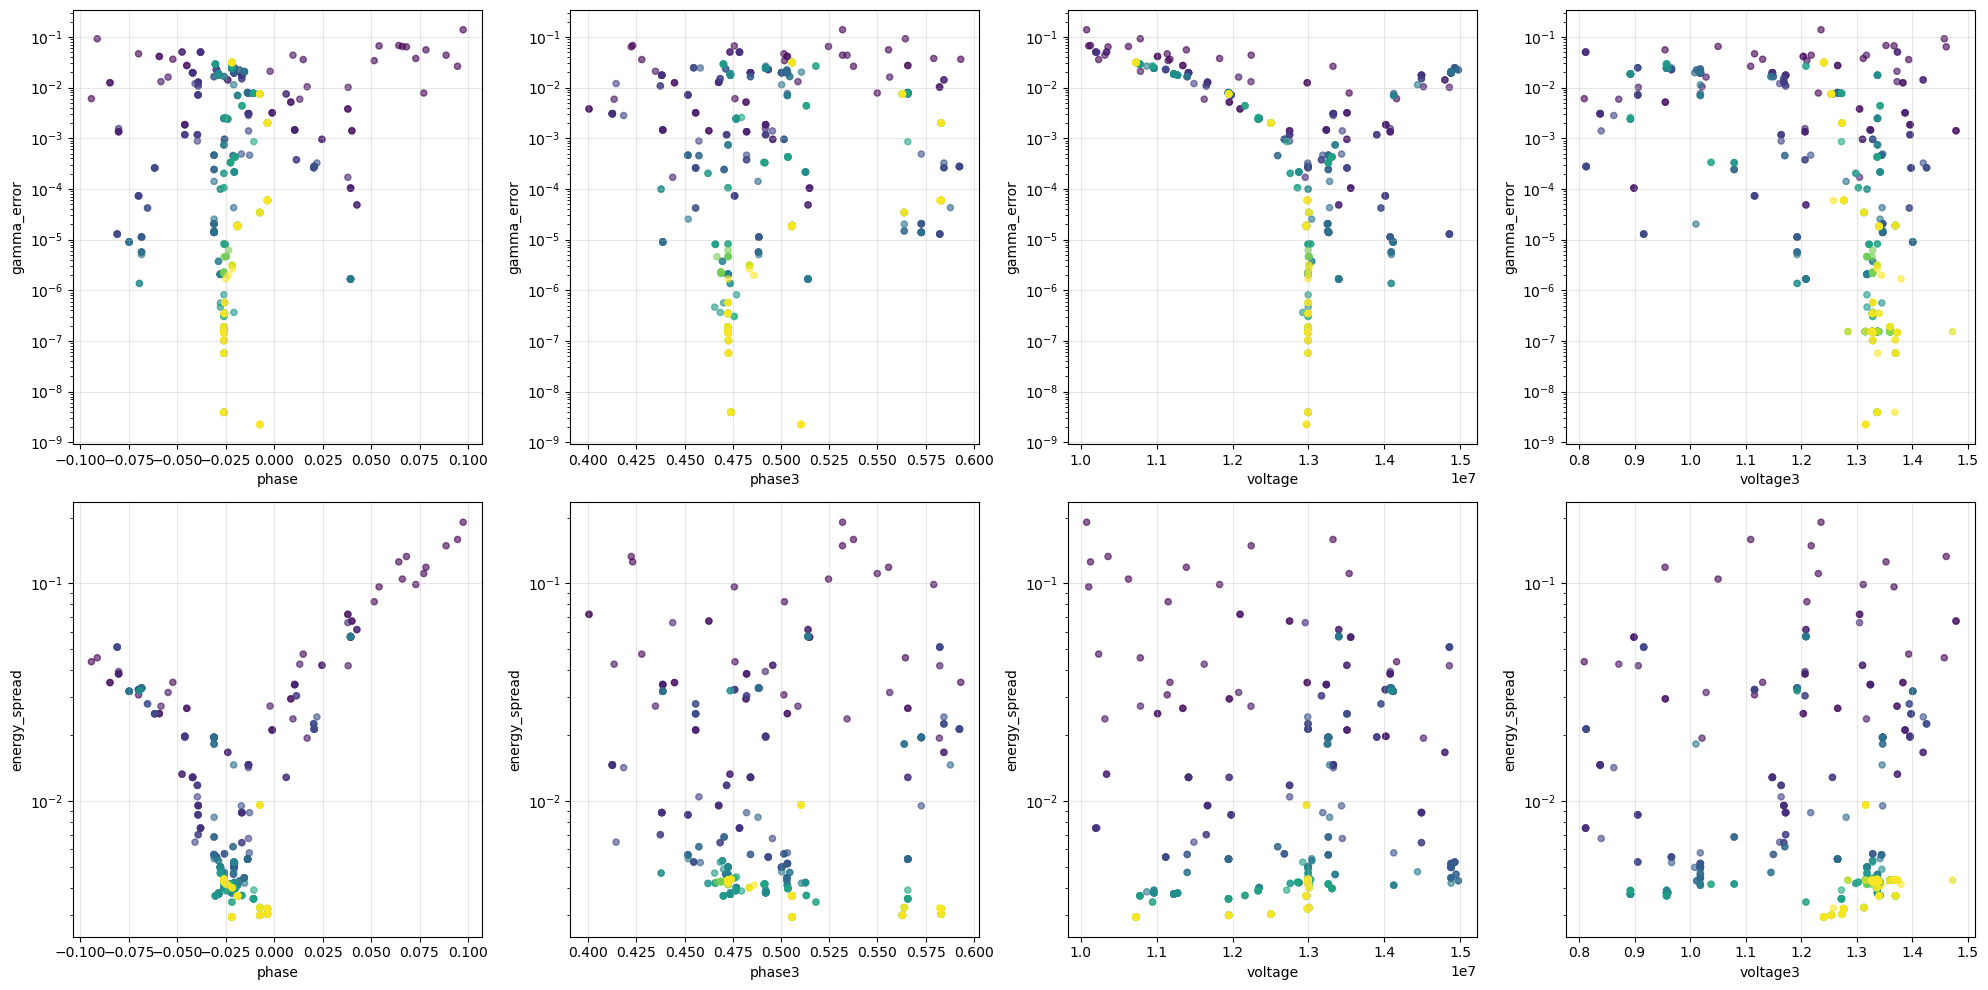

In [71]:
# 5. Variable vs Objective relationships
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, var in enumerate(variables):
    for j, obj in enumerate(objectives):
        ax = axes[j, i]
        ax.scatter(pop_df[var], pop_df[obj], alpha=0.6, s=20, c=pop_df['generation'], cmap='viridis')
        ax.set_xlabel(var)
        ax.set_ylabel(obj)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# 6. Find and analyze the best solutions
print("=== BEST SOLUTIONS ANALYSIS ===")

# Remove duplicates based on ID (keep first occurrence)
pop_df_unique = pop_df.drop_duplicates(subset=['ID'], keep='first')
print(f"Original solutions: {len(pop_df)}")
print(f"Unique solutions (after removing duplicates): {len(pop_df_unique)}")

# Find Pareto optimal solutions (non-dominated)
def is_dominated(row, df):
    """Check if a solution is dominated by any other solution"""
    for _, other_row in df.iterrows():
        if (other_row['gamma_error'] <= row['gamma_error'] and 
            other_row['energy_spread'] <= row['energy_spread'] and
            (other_row['gamma_error'] < row['gamma_error'] or 
             other_row['energy_spread'] < row['energy_spread'])):
            return True
    return False

# Find non-dominated solutions from unique dataset
pareto_front = []
for idx, row in pop_df_unique.iterrows():
    if not is_dominated(row, pop_df_unique):
        pareto_front.append(row)

pareto_df = pd.DataFrame(pareto_front)
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

=== BEST SOLUTIONS ANALYSIS ===
Original solutions: 672
Unique solutions (after removing duplicates): 186


Number of Pareto optimal solutions: 46


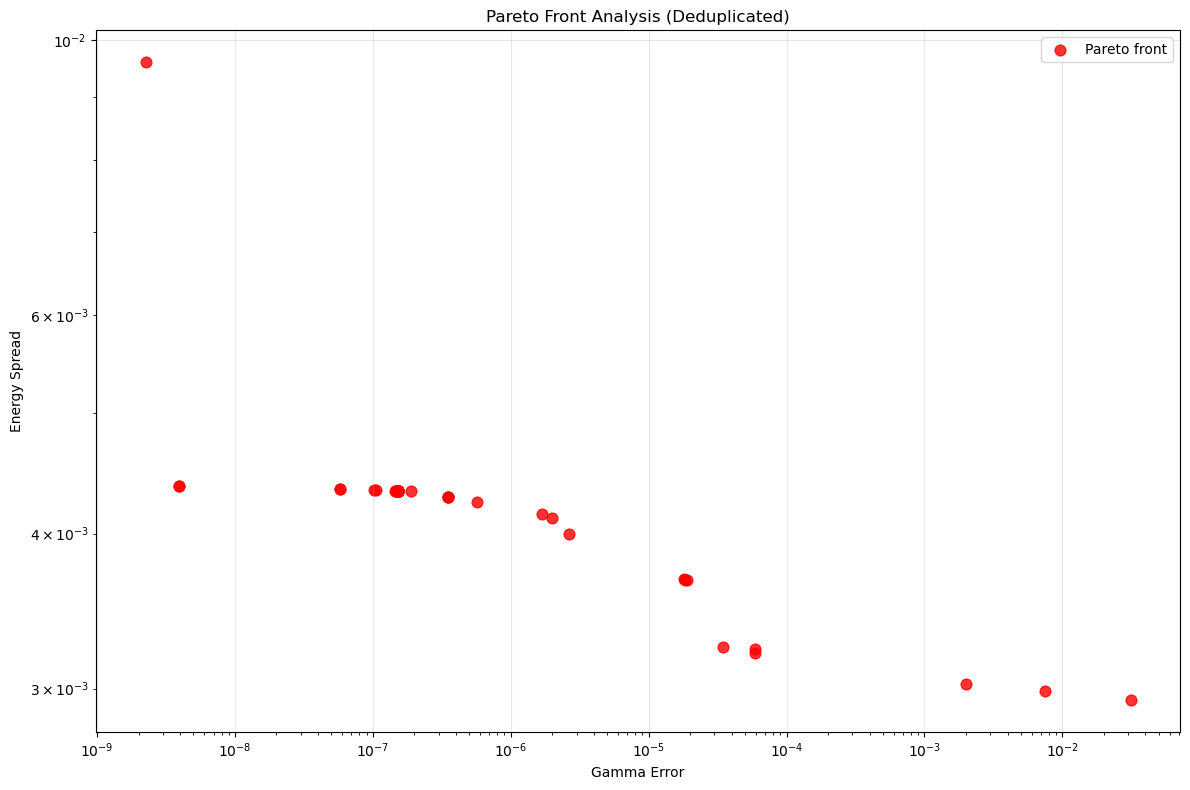

In [73]:
# 7. Plot Pareto front with best solutions highlighted
fig, ax = plt.subplots(figsize=(12, 8))

# All unique solutions
#ax.scatter(pop_df_unique['gamma_error'], pop_df_unique['energy_spread'], 
#          alpha=0.3, s=30, c='lightblue', label='All unique solutions')

# Pareto front
ax.scatter(pareto_df['gamma_error'], pareto_df['energy_spread'], 
          alpha=0.8, s=60, c='red', label='Pareto front')

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Pareto Front Analysis (Deduplicated)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

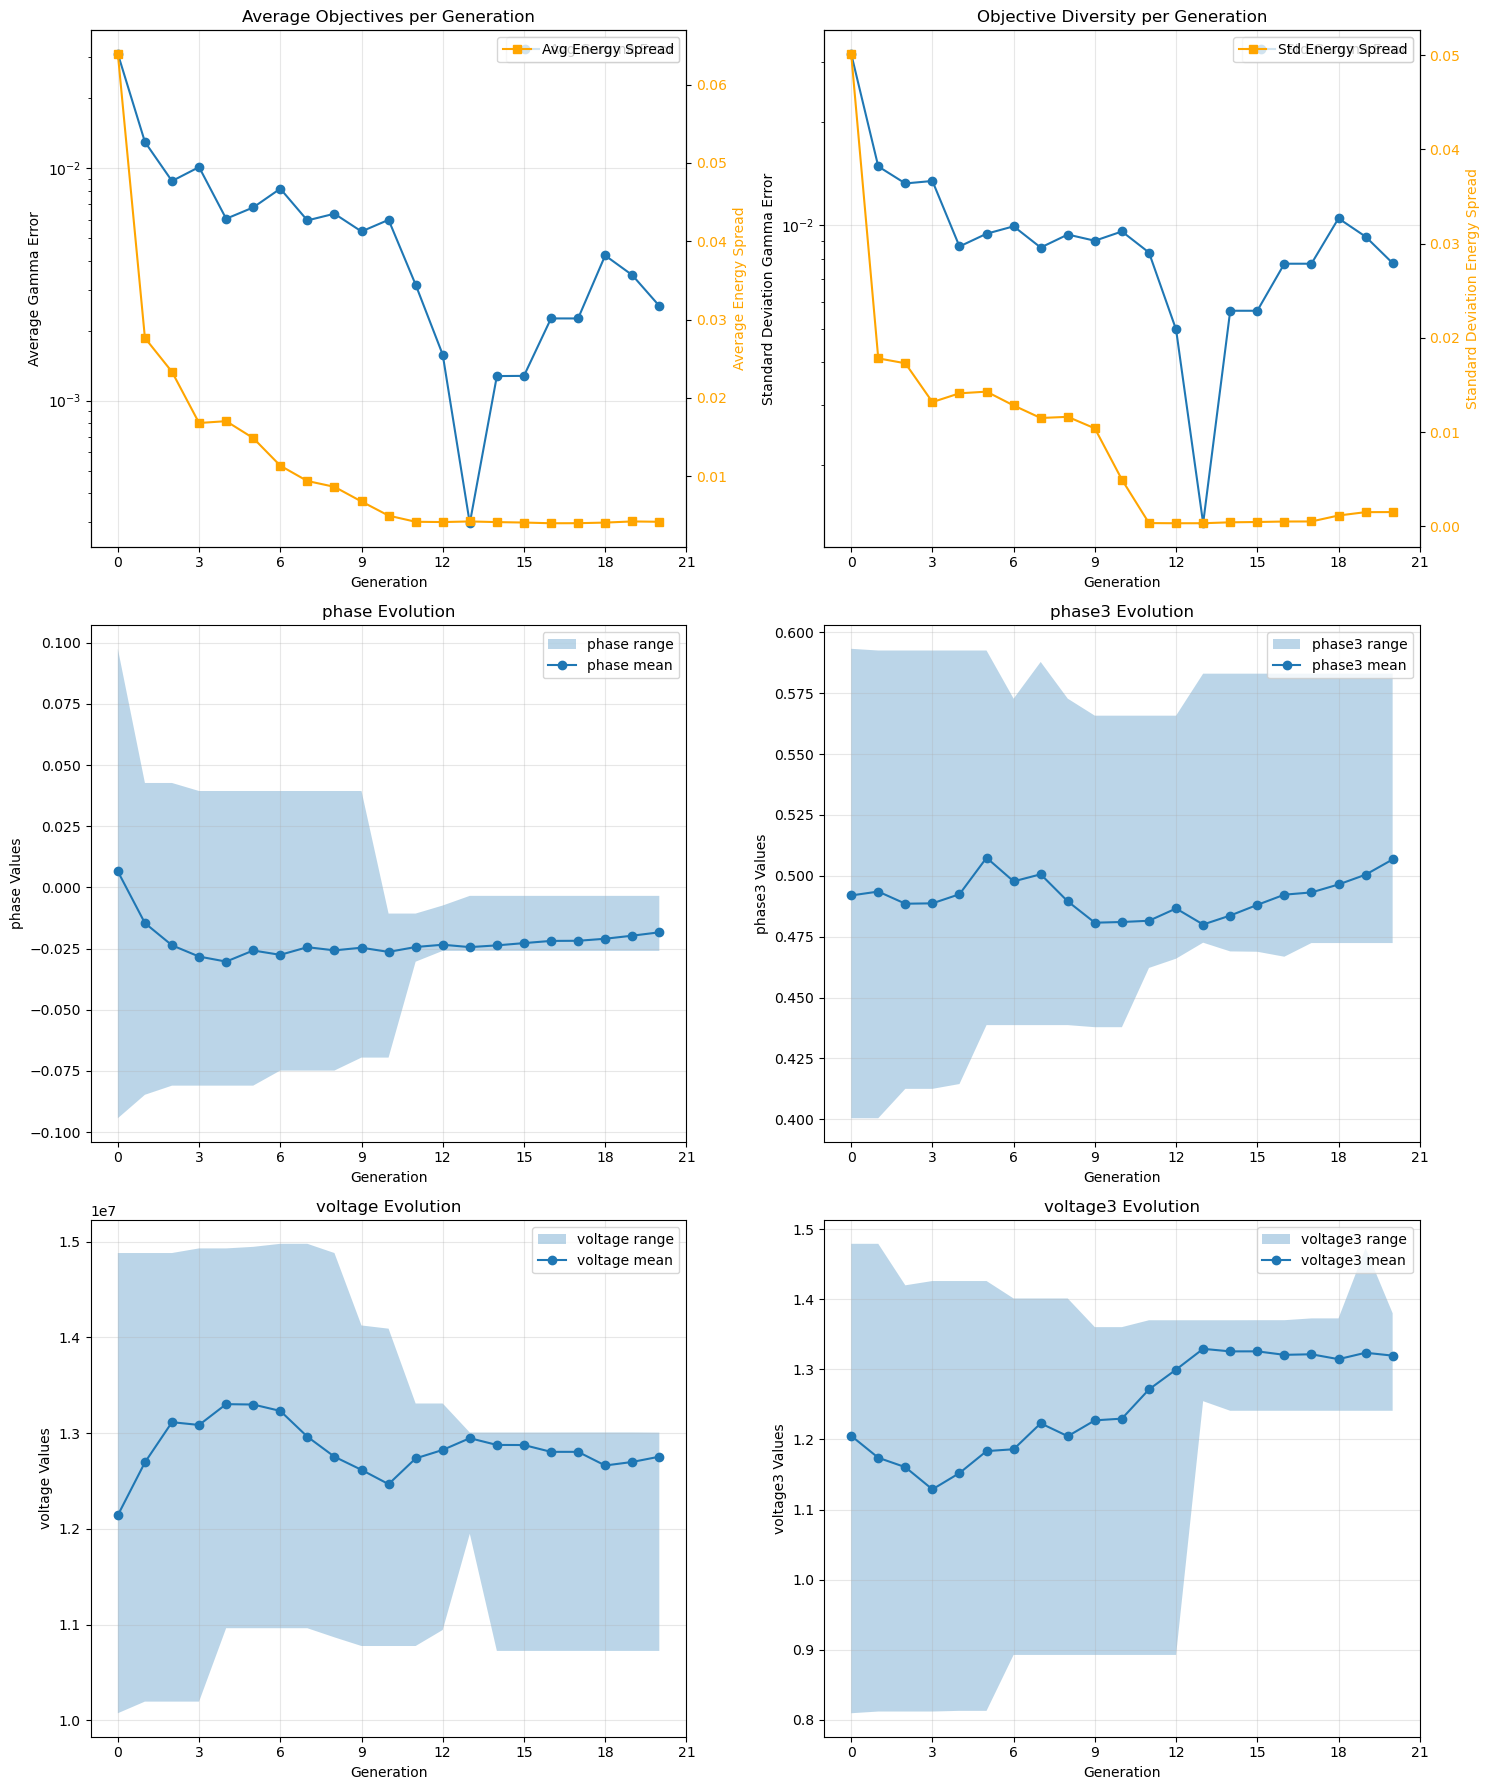

In [74]:
# 8. Generation-wise analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Average objectives per generation
avg_obj = pop_df.groupby('generation')[objectives].mean()
axes[0,0].plot(avg_obj.index, avg_obj['gamma_error'], 'o-', label='Avg Gamma Error')
axes[0,0].set_xlabel('Generation')
axes[0,0].set_ylabel('Average Gamma Error')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Average Objectives per Generation')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2 = axes[0,0].twinx()
ax2.plot(avg_obj.index, avg_obj['energy_spread'], 's-', color='orange', label='Avg Energy Spread')
ax2.set_ylabel('Average Energy Spread', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Standard deviation of objectives per generation
std_obj = pop_df.groupby('generation')[objectives].std()
axes[0,1].plot(std_obj.index, std_obj['gamma_error'], 'o-', label='Std Gamma Error')
axes[0,1].set_xlabel('Generation')
axes[0,1].set_ylabel('Standard Deviation Gamma Error')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Objective Diversity per Generation')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()
axes[0,1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax3 = axes[0,1].twinx()
ax3.plot(std_obj.index, std_obj['energy_spread'], 's-', color='orange', label='Std Energy Spread')
ax3.set_ylabel('Standard Deviation Energy Spread', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')
ax3.legend(loc='upper right')

# Individual variable evolution - each variable gets its own plot
var_positions = [axes[1,0], axes[1,1], axes[2,0], axes[2,1]]

for i, var in enumerate(variables):
    var_stats = pop_df.groupby('generation')[var].agg(['min', 'max', 'mean'])
    ax = var_positions[i]
    
    ax.fill_between(var_stats.index, var_stats['min'], var_stats['max'], 
                   alpha=0.3, label=f'{var} range')
    ax.plot(var_stats.index, var_stats['mean'], 'o-', label=f'{var} mean')
    ax.set_xlabel('Generation')
    ax.set_ylabel(f'{var} Values')
    ax.set_title(f'{var} Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [75]:
# 9. Select solutions from Pareto front and read particle data
print("=== PARETO FRONT SOLUTIONS ===")
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

# Display Pareto front solutions with their IDs
print("\nPareto front solutions:")

# Best solutions
best_gamma = pareto_df.sort_values(by=['gamma_error', 'energy_spread'])

pareto_display = best_gamma[['ID', 'mean_gamma'] + objectives]
print(pareto_display)


=== PARETO FRONT SOLUTIONS ===
Number of Pareto optimal solutions: 46

Pareto front solutions:
                                   ID  mean_gamma   gamma_error  energy_spread
578  38ccada2929741ea4d19ea54791e9773   25.401205  2.249232e-09       0.009597
445  df2f2c811710c97e4d242825ed48688d   25.398411  3.914428e-09       0.004371
644  f93fe281310671e9bcb04b9c543b4b2f   25.398411  3.914428e-09       0.004371
492  4796a9db096641686cddadf28c971f54   25.406092  5.753359e-08       0.004342
662  c842bec7cea401533969b22efb552285   25.406092  5.753359e-08       0.004342
494  8fd184c18569dd996ec9e2086029c65b   25.408127  1.023828e-07       0.004337
629  98d793ae4207f9237ec7d0c894ed2616   25.408226  1.048874e-07       0.004336
595  1a4ce86ded46ae130191d9f8a3fbad90   25.409703  1.459260e-07       0.004332
636  b2115eaa8654417361b68f171a5e0dc7   25.409736  1.469147e-07       0.004332
495  e692a937fd30a3e2b163b093bd7ddef5   25.409738  1.469952e-07       0.004332
562  7182cde17f307dfad910ab37692f1e7

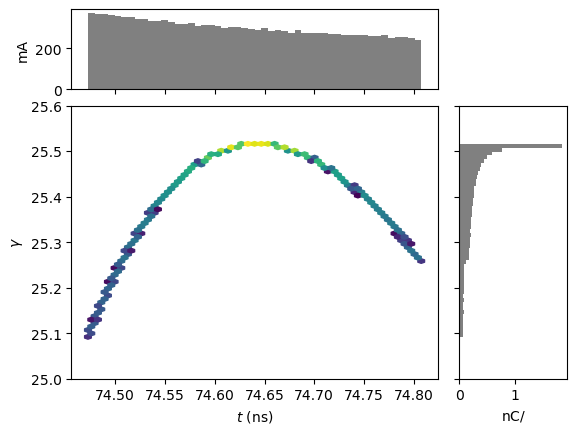

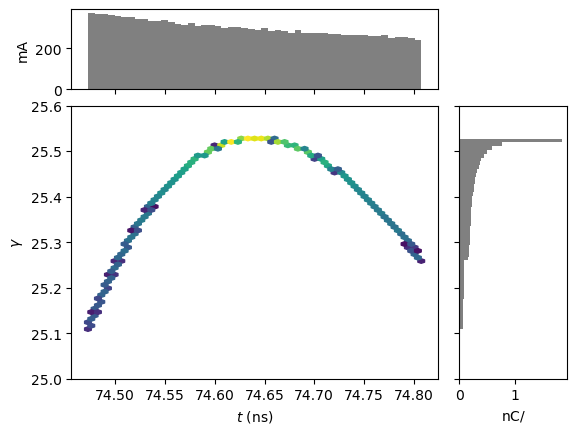

In [57]:
selected_ID = ["df2f2c811710c97e4d242825ed48688d", "c10c99213621d9080f1b62be60bcf9cc"]
pgs = []
global_y_limits = (25, 25.6)

for i, ID in enumerate(selected_ID):    
    # Read particle data
    pg = ParticleGroup("temp/" + ID + ".h5")
    pgs.append(pg)
    pg.plot('t', 'gamma', ylim=global_y_limits)

In [65]:
idx = 1
pgs[idx]['mean_gamma'], pgs[idx]['sigma_energy']

(25.409944697886363, 56234.3797903907)

In [63]:
pgs[idx]['mean_energy']

12978561.270497521